<a href="https://colab.research.google.com/github/KimDongChan0908/Artificial-Intelligence-Programming/blob/week---13---class/CIFAR_10_Model_%3D_resnet152_(pretrained_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install py7zr #아카이브 포맷파일을 압축하거나 해제하는데 사용하는 라이브러리

#Import Library

In [2]:
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision import models
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

from py7zr import unpack_7zarchive
import shutil
shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)

In [23]:
num_epochs = 3
batch_size = 32
lr = 0.01

#Dataset

In [11]:
class CifarLoader(Dataset):
  def __init__(self, root_dir, csv_file = None, transform = None):

    # images directory
    self.root_dir = root_dir
    # transformations if any
    self.transform = transform

    if csv_file:
      # read csv file
      self.df = pd.read_csv(csv_file)

      # {class: lbl}
      self.annot_dict = {}

      for i, lbl in enumerate(self.df['label'].unique()):
        self.annot_dict[lbl] = i

      # {lbl: class}
      self.annot_dict_reversed = {v:k for k,v in self.annot_dict.items()}

      # add a column with decoded labels
      self.df['encoded'] = self.df['label'].map(self.annot_dict)

    else:
      # if no csv file provided -> create a df, fill labels with 0's
      self.df = pd.DataFrame({
          'id': list(range(1, len(os.listdir(self.root_dir)) + 1)),
          'label': np.zeros(len(os.listdir(self.root_dir))),
          'encoded': np.zeros(len(os.listdir(self.root_dir)))
      })


  def __len__(self):
    # num of records in the df
    return len(self.df)

  def __getitem__(self, index):
    # path to the image
    img_path = os.path.join(self.root_dir, str(self.df.iloc[index, 0]) + '.png')
    # read image
    image = np.array(Image.open(img_path).convert('RGB'))
    # get label
    y_label = torch.tensor(int(self.df.iloc[index, 2]))

    # apply transformations
    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [13]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25,0.25,0.25])

tr = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

#Data Unpacking

In [14]:
shutil.unpack_archive('/content/train.7z')

In [15]:
dataset = CifarLoader(csv_file = '/content/trainLabels.csv',
                      root_dir = '/content/train',
                      transform = tr)

print(dataset.df.head())

   id       label  encoded
0   1        frog        0
1   2       truck        1
2   3       truck        1
3   4        deer        2
4   5  automobile        3


#Split  The Data

In [16]:
indexes = list(range(len(dataset)))

train_indexes, val_indexes = train_test_split(indexes, test_size=0.2)

data = {}
data['train'] = Subset(dataset, train_indexes)
data['val'] = Subset(dataset, val_indexes)

dataloader_train = DataLoader(dataset = data['train'], batch_size = batch_size, shuffle=False)
dataloader_val = DataLoader(dataset = data['val'], batch_size = batch_size, shuffle=False)

In [17]:
print(len(train_indexes), len(val_indexes))

40000 10000


#Show Images

In [19]:
def images_show(images, lbls=None):
  for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = images[i].numpy().transpose((1, 2, 0)) #numpy로 변환

    img = img * std + mean
    img = np.clip(img, a_min=0, a_max=1)
    plt.imshow(img)

    if lbls != None:

      plt.title(dataset.annot_dict_reversed[lbls[i].item()])
    plt.axis('off')
    plt.tight_layout(pad=0.5)
    plt.show()

# Pretrained Model upload - resnet152

In [20]:
model = models.resnet152(pretrained=True)

num_ftrs = model.fc.in_features

model.classifier = nn.Sequential(
                        nn.Linear(num_ftrs, 256),
                        nn.ReLU(),
                        nn.Dropout(0.3),
                        nn.Linear(256, 10))

model_wts = copy.deepcopy(model.state_dict())

model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 177MB/s]


In [21]:
def train(
        model, criterion, optimizer,
        num_epochs, dataloader_train,
        dataloader_val = None):

  history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'best train acc': (0, 0)
        }

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0


  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))

    model.train()

    n_samples = 0
    correct_train = 0
    epoch_loss_train = 0
    epoch_loss_val = 0


    for i, (images, labels) in enumerate(dataloader_train):

      images = images.to(device)
      labels = labels.to(device)

      pred = model(images)

      loss = criterion(pred, labels)

      epoch_loss_train += labels.shape[0] * loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      value, predicted = torch.max(pred, 1)

      n_samples += labels.shape[0] #batch_size + -
      correct_train += (predicted==labels).sum().item()

    train_acc = 100 * correct_train / n_samples
    epoch_loss_train = epoch_loss_train / n_samples

    print(f'Train accuracy: {train_acc:.2f}, loss: {epoch_loss_train:.2f}')

    history['accuracy'].append(train_acc)
    history['loss'].append(epoch_loss_train)

    if train_acc > best_acc:

      best_acc = train_acc

      best_model_wts = copy.deepcopy(model.state_dict())
      history['best train acc'] = (epoch, best_acc)



    if dataloader_val:

      model.eval()

      with torch.no_grad():
        correct_val = 0
        n_samples = 0

        for images, labels in dataloader_val:
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)

          loss = criterion(outputs, labels)
          epoch_loss_val += labels.shape[0] * loss.item()

          _, pred = torch.max(outputs, 1)
          n_samples += labels.shape[0]
          correct_val += (pred==labels).sum().item()

        val_acc = 100 * correct_val / len(data['val'])
        epoch_loss_val = epoch_loss_val / len(data['val'])

        print(f'Val accuracy: {val_acc:.2f}, loss: {epoch_loss_val:.2f}')

        history['val_accuracy'].append(val_acc)
        history['val_loss'].append(epoch_loss_val)

    print('=' * 80)

  print('Best train acc: {:2f}'.format(best_acc))

  model.load_state_dict(best_model_wts)

  return model, history

In [24]:
model, history = train(model, criterion, optimizer, num_epochs,
                       dataloader_train, dataloader_val)

Epoch 1/3
Train accuracy: 89.54, loss: 0.35
Val accuracy: 95.37, loss: 0.14
Epoch 2/3
Train accuracy: 98.63, loss: 0.05
Val accuracy: 96.75, loss: 0.11
Epoch 3/3
Train accuracy: 99.91, loss: 0.01
Val accuracy: 96.93, loss: 0.11
Best train acc: 99.905000


In [27]:
def plot_history(history):

    loss = history['loss']
    accuracy = history['accuracy']
    val_loss = history['val_loss']
    val_accuracy = history['val_accuracy']
    x = range(len(loss))

    plt.figure(figsize = (12,5))
    plt.subplot(1,2,1)
    plt.plot(x, accuracy, label='Training acc', color='#03045e', linewidth=2)\

    if len(val_loss) != 0:
        plt.plot(x, val_accuracy, label='Validation acc', color='#48cae4', linewidth=2)
    plt.plot(history['best train acc'][0],
    history['best train acc'][1],
    'bo', label='Best train acc', markersize=7, color='black')
    plt.title('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.subplot(1, 2, 2)


    plt.plot(x, loss, label='Training loss', color='#03045e', linewidth=2)
    if len(val_loss) != 0:
        plt.plot(x, val_loss, label='Validation loss', color='#48cae4', linewidth=2)
    plt.title('Loss')
    plt.grid(True)
    plt.legend()

# Learning Curve

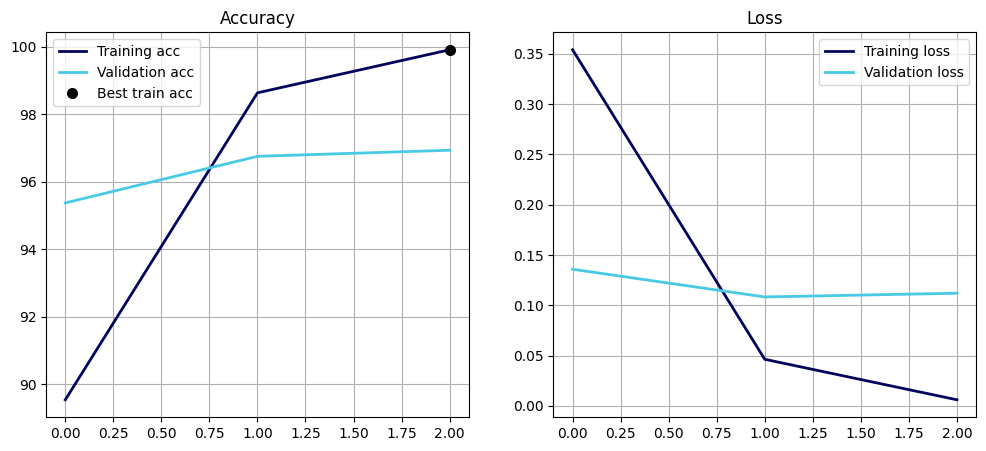

In [28]:
plot_history(history)

#Evaluate

In [33]:
def evaluate(model, dataloader):

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      # value, index
      v, pred = torch.max(outputs, 1)

      n_samples += labels.shape[0]
      n_correct += (pred==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [34]:
evaluate(model, dataloader_val)

96.93
